Lecture 3 (practice)
======================


## About

For this part of the assignment, you will gain hands-on experience working with Visual Transformers (ViT).

* Fine-tuning ViT model:

Fine-tune the ViT model on the CIFAR-10, DTD, and COCO-O datasets using HuggingFace lib.


<hr> 

* The <b><font color="red">red</font></b> color indicates the task that should be done, like <b><font color="red">[TODO]</font></b>: ...
* Addicitional comments, hints are in <b><font color="blue">blue</font></b>. For example <b><font color="blue">[HINT]</font></b>: ...

## Prelimiaries

In [38]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

import fiftyone as fo

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [39]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Load data

In [2]:
# Set the local folder with the data
path_data = "./data"
os.makedirs(path_data, exist_ok=True)

In [3]:
# Load cifar10 dataset
cifar10_dataset = load_dataset('cifar10', cache_dir=path_data)
cifar10_classes_list = cifar10_dataset['train'].features['label'].names

In [4]:
# Load DTD dataset
dtd_dataset = load_dataset("tanganke/dtd", cache_dir=path_data)
dtd_classes_list = dtd_dataset['train'].features['label'].names

In [5]:
# Prepare COCO-O dataset
if not os.path.exists(os.path.join(path_data, 'ood_coco')):
    url = 'https://drive.google.com/uc?id=1aBfIJN0zo_i80Hv4p7Ch7M8pRzO37qbq'
    zip_file_path = os.path.join(path_data, 'ood_coco.zip')
    gdown.download(url, zip_file_path, quiet=False)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path_data)
cocoo_classes_list = os.listdir(os.path.join(path_data, 'ood_coco'))

## Auxilary functions

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

def processor_transform(processor):
    def curry(example_batch):
        inputs = processor([x for x in example_batch['img']], return_tensors='pt')
        inputs['labels'] = example_batch['label']
        return inputs
    return curry

## Training

### cifar10

In [7]:
# We will use the 'base' version of the ViT family
model_name = "google/vit-base-patch16-224"

In [8]:
# Special object for preprocessing
processor = ViTImageProcessor.from_pretrained(model_name) 

In [9]:
# Set the transform to match what the processor expects
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

In [10]:
# Load pretrain model
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


In [11]:
# Set the correct number of classes
num_classes = len(cifar10_classes_list)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [12]:
# Training arguments
args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',    
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
)

In [25]:
# We will take a small subset of the dataset to speed up things
n_train = 2000
n_test = 1000
train_subset = cifar10_dataset['train'].select(range(n_train))
test_subset = cifar10_dataset['test'].select(range(n_test))

# prepare data for Trainer
transform_func = processor_transform(processor)
ds_train = train_subset.with_transform(transform_func)
ds_test = test_subset.with_transform(transform_func)

ds_test_full = cifar10_dataset['test'].with_transform(transform_func)

In [23]:
# Define 'Trainer'
trainer = Trainer(
    model,
    args, 
    train_dataset=ds_train,
    eval_dataset=ds_test,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [24]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.018488,0.886200
2,No log,0.648975,0.931200
3,No log,0.558352,0.938200


TrainOutput(global_step=96, training_loss=0.8356031576792399, metrics={'train_runtime': 365.4058, 'train_samples_per_second': 8.21, 'train_steps_per_second': 0.263, 'total_flos': 2.32492637712384e+17, 'train_loss': 0.8356031576792399, 'epoch': 3.0})

In [26]:
# Predict
outputs = trainer.predict(ds_test_full)
print(outputs.metrics)

{'test_loss': 0.563393771648407, 'test_accuracy': 0.9357, 'test_runtime': 153.2434, 'test_samples_per_second': 65.256, 'test_steps_per_second': 2.043}


In [35]:
predictations = outputs.predictions.argmax(1)

In [36]:
true_labels = cifar10_dataset['test']['label']

In [37]:
# Detailed analysis (report)
print(classification_report(true_labels, predictations, target_names=cifar10_classes_list))

              precision    recall  f1-score   support

    airplane       0.96      0.93      0.94      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.91      0.91      0.91      1000
         cat       0.89      0.86      0.88      1000
        deer       0.91      0.96      0.93      1000
         dog       0.91      0.92      0.91      1000
        frog       0.97      0.96      0.97      1000
       horse       0.97      0.95      0.96      1000
        ship       0.97      0.97      0.97      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



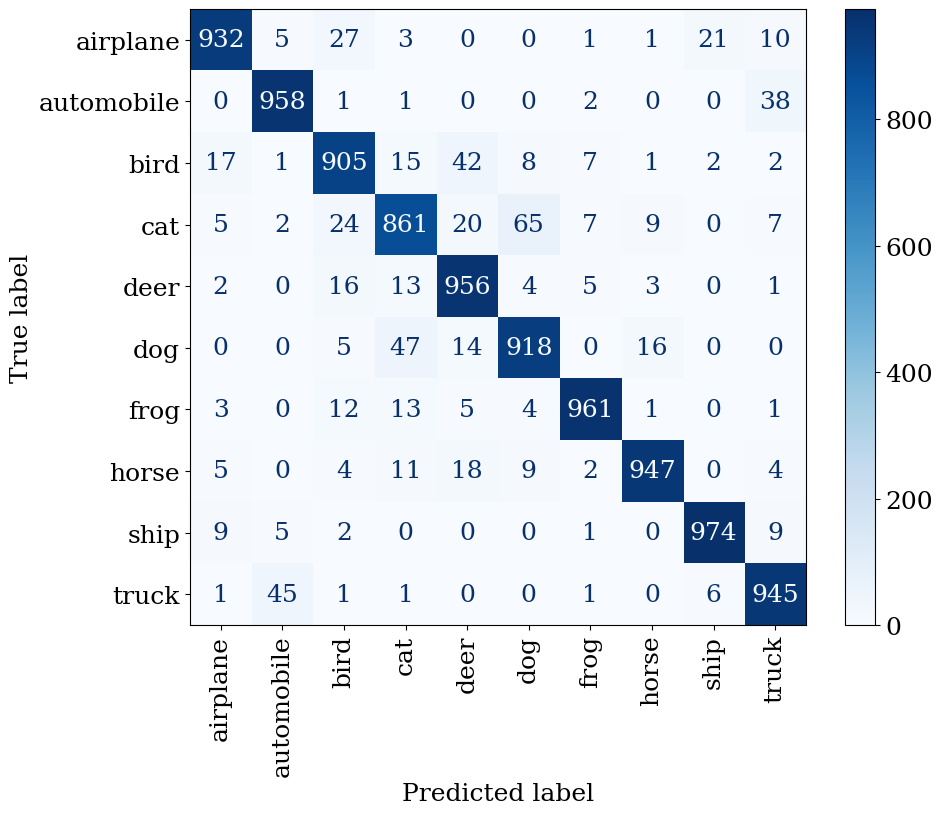

In [47]:
# Detailed analysis (confusion matrix)

cm = confusion_matrix(true_labels, predictations)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_classes_list)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90);

### DTD

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for DTD dataset. What is the accuracy, how does it compare to the cnn-based experiments?

### COCO-O

<b><font color="red">[TODO]</font></b>: Conduct fine-tuning experiments for COCO-O dataset. What is the accuracy, What is the accuracy, how does it compare to the cnn-based experiments?

## Analysis of the results with FiftyOne lib

<b><font color="red">[TODO]</font></b>: Using the example from the previous 'Practice (Lecture 1)' session and the guidance from the provided [LINK](https://docs.voxel51.com/recipes/adding_classifications.html), analyze the COCO-O results using the FiftyOne tool. Specifically, focus on examining instances where the predictions do not align with the ground truth labels.